#### Connect to database

In [1]:
# Connect to Postgres
import os
import psycopg2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def newCursor():
    try:
        connection = psycopg2.connect(user = os.environ["DB_USER"],
                                      host = os.environ["DB_HOST"],
                                      password = os.environ["DB_PASSWORD"],
                                      port = "5432",
                                      database = os.environ["DB_DATABASE"])

        cursor = connection.cursor()
        return cursor

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
        return error
    

#### Querying relevant columns

In [30]:
c = newCursor()
q = """
SELECT *
FROM api."WEETS_reference_SyntheticIndividuals"
WHERE sex = 'female' -- AND age >=18;
"""
# age not properly filtered out!

c.execute(q)
cols = [desc[0] for desc in c.description]
df = pd.DataFrame(c.fetchall(), columns=cols)

orig_df = df

# print(df.head(5))

df = df[['age_group', 'ethnic_group', 'nationality', 'marital_and_civil_partnership_status', 
    'no_of_dependents', 'residential_status', 'highest_level_of_qualifications', 'employment_status', 
    'have_a_mortgage', 'have_other_borrowing', 'uk_passport_no', 'residence_permit_no', 'international_passport', 
    'drivers_license_no', 'credit_rating']]
    
df.head()

,age_group,ethnic_group,nationality,marital_and_civil_partnership_status,no_of_dependents,residential_status,highest_level_of_qualifications,employment_status,have_a_mortgage,have_other_borrowing,uk_passport_no,residence_permit_no,international_passport,drivers_license_no,credit_rating
0,55+,White,United Kingdom,Married / civil partnership,two,Owned with a mortgage or loan,Level 1,Employee: Full-time,Yes,No,5302338224GBR,,,,Good
1,,White,Italy,Single,zero,Living rent free,No qualifications,Other,No,No,,CC40601219,T99347956380ITA,,
2,51-55,White,United Kingdom,Single,one,Owned outright,Level 1,Homemaker,No,No,1366019281GBR,,,SMITH640147L99AM,Fair
3,51-55,White,United Kingdom,Single,two,Owned outright,Level 4 or above,Employee: Full-time,No,No,2715365418GBR,,,HARRI640098F99QN,Fair
4,55+,White,United Kingdom,Single,three or more,Owned outright,No qualifications,Retired,No,No,3514153243GBR,,,KAUR9451196B99NZ,Excellent


#### Data processing

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253762 entries, 0 to 253761
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   age_group                             253762 non-null  object
 1   ethnic_group                          253762 non-null  object
 2   nationality                           253762 non-null  object
 3   marital_and_civil_partnership_status  253762 non-null  object
 4   no_of_dependents                      253762 non-null  object
 5   residential_status                    253762 non-null  object
 6   highest_level_of_qualifications       253762 non-null  object
 7   employment_status                     253762 non-null  object
 8   have_a_mortgage                       253762 non-null  object
 9   have_other_borrowing                  253762 non-null  object
 10  uk_passport_no                        253762 non-null  object
 11  residence_per

In [32]:
# filtering out children
df = df[df['age_group'] != '']

In [33]:
df['is_poc'] = np.where(df.loc[:, 'ethnic_group'].isin(['White']), 0, 1) 
df = df.drop('ethnic_group', axis=1)

df['is_foreign_national'] = np.where(df.loc[:, 'nationality'].isin(['United Kingdom']), 0, 1) 
df = df.drop('nationality', axis=1)

df['has_children'] = np.where(df.loc[:, 'no_of_dependents'].isin(['zero']), 0, 1) 
df = df.drop('no_of_dependents', axis=1)

df['has_a_mortgage'] = np.where(df.loc[:, 'have_a_mortgage'].isin(['No']), 0, 1) 
df = df.drop('have_a_mortgage', axis=1)

df['has_uk_passport'] = np.where(df.loc[:, 'uk_passport_no'].isin(['']), 0, 1) 
df = df.drop('uk_passport_no', axis=1)

df['has_other_borrowing'] = np.where(df.loc[:, 'have_other_borrowing'].isin(['No']), 0, 1) 
df = df.drop('have_other_borrowing', axis=1)

df['has_residence_permit'] = np.where(df.loc[:, 'residence_permit_no'].isin(['']), 0, 1) 
df = df.drop('residence_permit_no', axis=1)

df['has_international_passport'] = np.where(df.loc[:, 'international_passport'].isin(['']), 0, 1) 
df = df.drop('international_passport', axis=1)

df['has_drivers_license'] = np.where(df.loc[:, 'drivers_license_no'].isin(['']), 0, 1) 
df = df.drop('drivers_license_no', axis=1)

In [34]:
# one-hot encoding; converting categorical column into multiple columns in binary format 

df_age= pd.get_dummies(df['age_group'])
df_qualifications= pd.get_dummies(df['highest_level_of_qualifications'])
df_credit= pd.get_dummies(df['credit_rating'])
df_marriage= pd.get_dummies(df['marital_and_civil_partnership_status'])
df_residential= pd.get_dummies(df['residential_status'])
df_employment= pd.get_dummies(df['employment_status'])

In [35]:
# merging the binary categorical data into df 

dfs = [df_credit, df_employment, df_marriage, df_age, df_qualifications, df_residential]
df = pd.concat(dfs, join='outer', axis=1)
df.head()

,Excellent,Fair,Good,Poor,Employee: Full-time,Employee: Part-time,Full-time student,Homemaker,Other,Retired,...,No qualifications,Other qualifications,Living rent free,Other,Owned outright,Owned with a mortgage or loan,Private rented,Rented from council (Local Authority),Shared ownership (part owned and part rented),Social rented
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,1,0,0,0,0,0
5,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [39]:
df.shape

(203928, 40)

In [28]:
# dropping 
df = df.drop(columns=df.columns[0]) # dropping nan column

In [ ]:
df.head()

In [ ]:
df.info()

In [12]:
df.isnull().sum() # checking for missing values

Fair                                             0
Good                                             0
Poor                                             0
Employee: Full-time                              0
Employee: Part-time                              0
Full-time student                                0
Homemaker                                        0
Other                                            0
Retired                                          0
Self-employed                                    0
Unemployed                                       0
Divorced / dissolved civil partnership           0
Married / civil partnership                      0
Separated                                        0
Single                                           0
Widowed / surviving civil partner                0
18-20                                            0
21-25                                            0
26-30                                            0
31-35                          

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5]),
 <a list of 40 Text major ticklabel objects>)

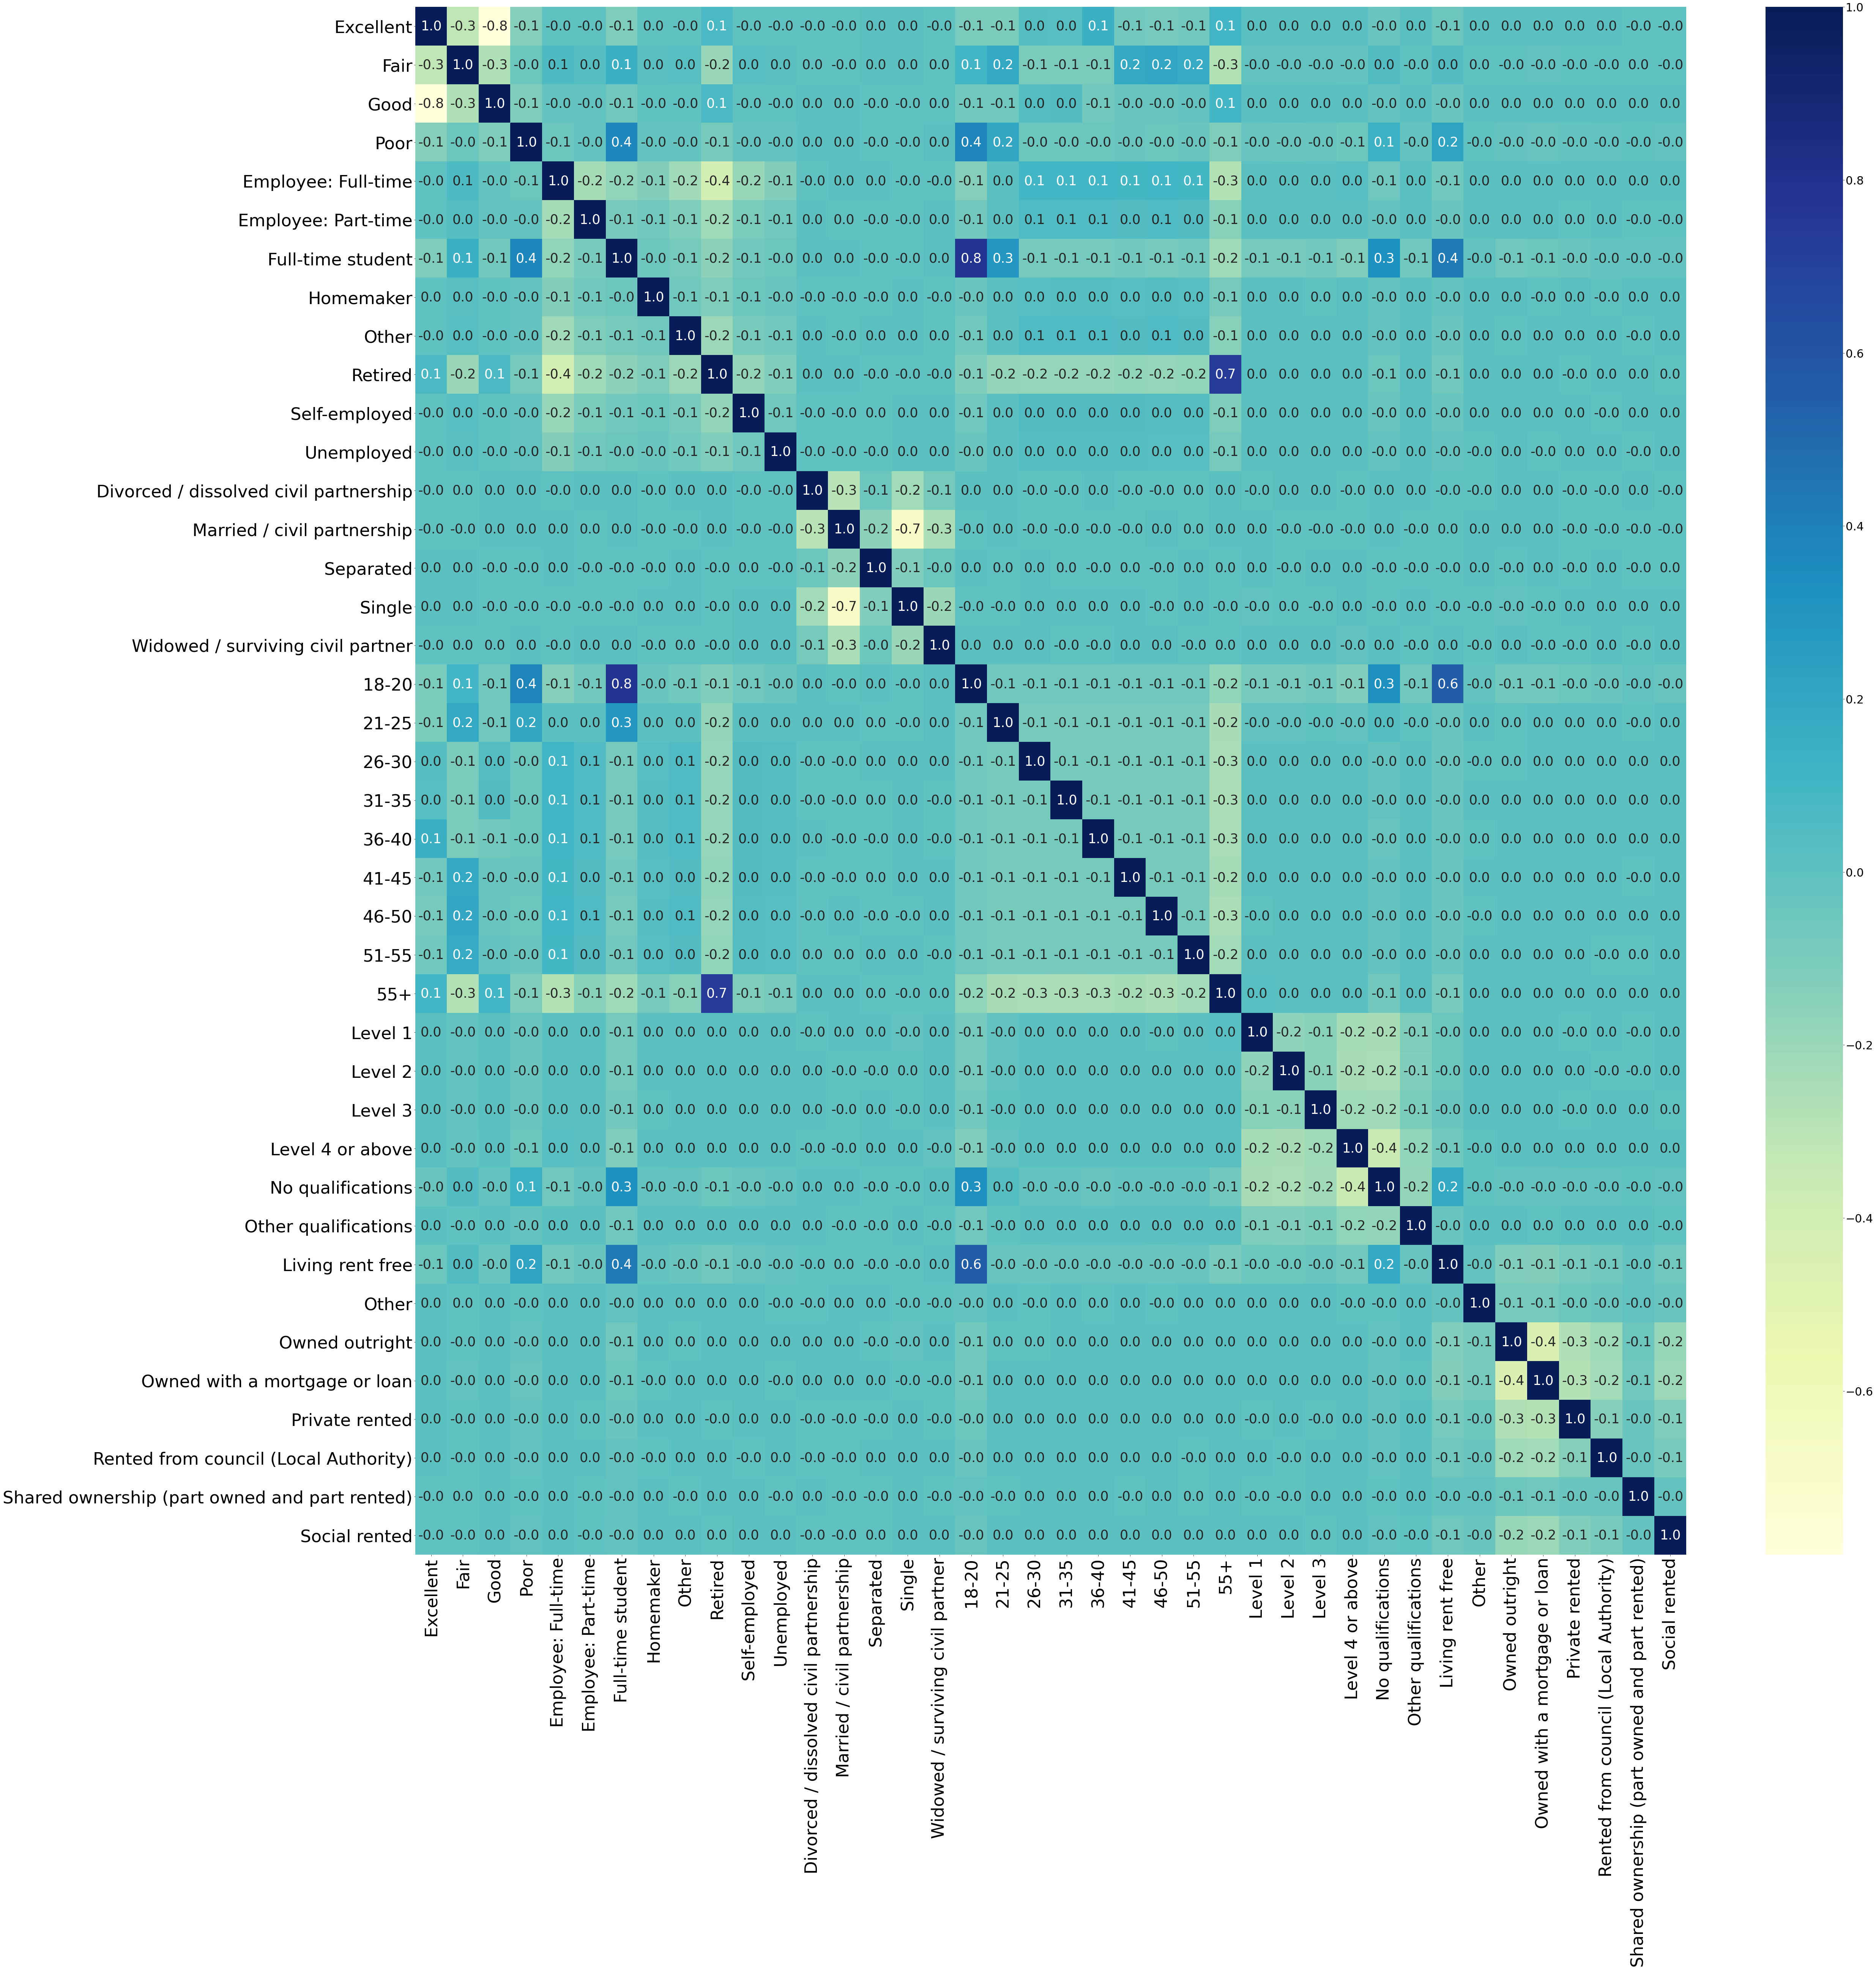

In [41]:
# correlation matrix showing correlation co-effiecients 
corr_matrix = df.corr()
plt.rcParams['figure.figsize'] = (60.0, 45.0)
heatMap = sns.heatmap(corr_matrix, annot=True,  cmap="YlGnBu", annot_kws={'size': 35}, fmt='.1f')
heatmap = plt.gcf()
heatmap.set_size_inches(75,75)
plt.xticks(fontsize=45)
plt.yticks(fontsize=45)

## Modelling

### Using the elbow method to find the optimal number of clusters

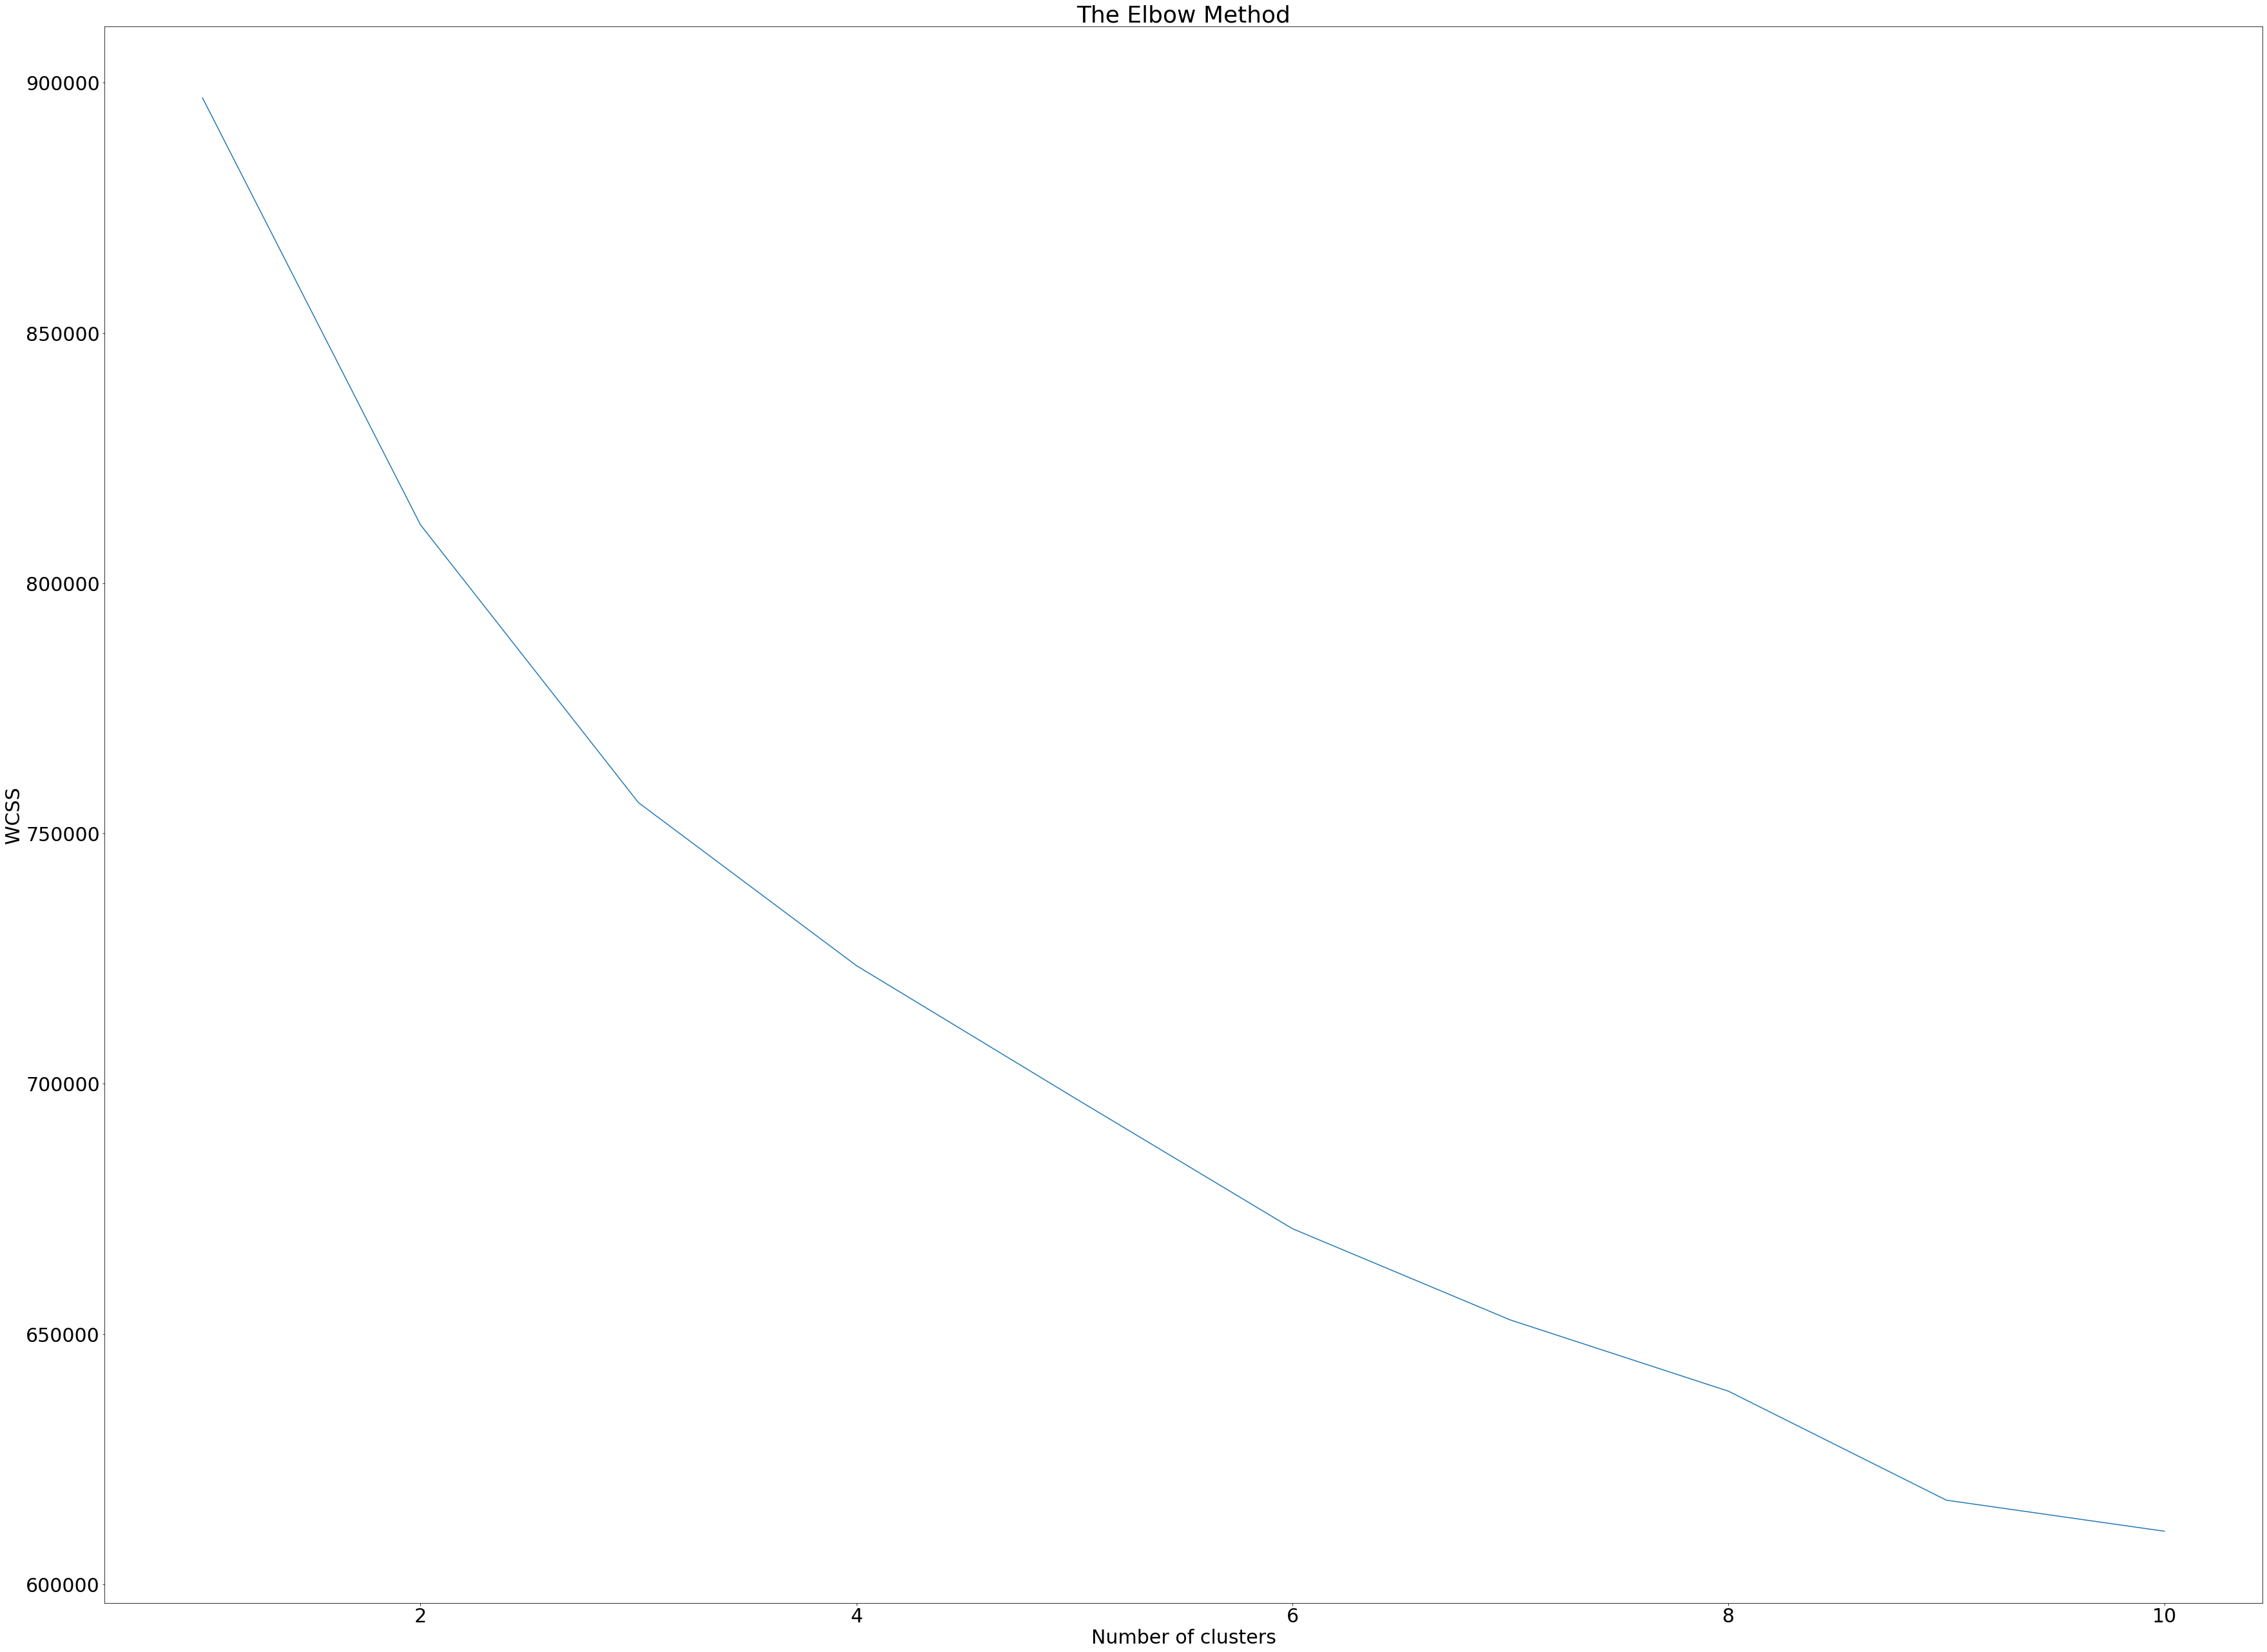

In [42]:
# K-Means clustering

from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.xticks(fontsize=45)
# plt.yticks(fontsize=45)
plt.rcParams.update({'font.size': 30})

plt.show()

In [ ]:
df.info

### Training the K-Means model 

In [43]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df)

In [244]:
# when k = 4

cluster_1 = df[y_kmeans == 0]
# full time employees with excellent credit

cluster_2 = df[y_kmeans == 1]
# full time students with no qualifications

cluster_3 = df[y_kmeans == 2]
# retired people 55+ with good credit

cluster_4 = df[y_kmeans == 3]
# working women with good credit

# cluster_4[['Self-employed', 'Unemployed',
#        'Divorced / dissolved civil partnership', 'Married / civil partnership',
#        'Separated', 'Single', 'Widowed / surviving civil partner', '18-20',
#        '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '55+',
#        'Level 1', 'Level 2', 'Level 3', 'Level 4 or above']].head(20)

cluster_4.head(20)

,Excellent,Fair,Good,Poor,Employee: Full-time,Employee: Part-time,Full-time student,Homemaker,Other,Retired,...,No qualifications,Other qualifications,Living rent free,Other,Owned outright,Owned with a mortgage or loan,Private rented,Rented from council (Local Authority),Shared ownership (part owned and part rented),Social rented
0,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
14,0,0,1,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
17,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
19,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
48,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
55,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
58,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
72,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
74,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
82,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [242]:
df.columns

Index(['Excellent', 'Fair', 'Good', 'Poor', 'Employee: Full-time',
       'Employee: Part-time', 'Full-time student', 'Homemaker', 'Other',
       'Retired', 'Self-employed', 'Unemployed',
       'Divorced / dissolved civil partnership', 'Married / civil partnership',
       'Separated', 'Single', 'Widowed / surviving civil partner', '18-20',
       '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '55+',
       'Level 1', 'Level 2', 'Level 3', 'Level 4 or above',
       'No qualifications', 'Other qualifications', 'Living rent free',
       'Other', 'Owned outright', 'Owned with a mortgage or loan',
       'Private rented', 'Rented from council (Local Authority)',
       'Shared ownership (part owned and part rented)', 'Social rented'],
      dtype='object')

In [47]:
# when k = 6

cluster_1 = df[y_kmeans == 0]
# full time working women with fair credit

cluster_2 = df[y_kmeans == 1]
# retired 55+ married women with good credit

cluster_3 = df[y_kmeans == 2]
# retired 55+ women with excellent credit 

cluster_4 = df[y_kmeans == 3]
# working women with few qualifications and good credit

cluster_5 = df[y_kmeans == 4]
# married 30+ working women with excellent credit

cluster_6 = df[y_kmeans == 5]
# single 30+ working women with excellent credit

# cluster_1[['Self-employed', 'Unemployed',
#        'Divorced / dissolved civil partnership', 'Married / civil partnership',
#        'Separated', 'Single', 'Widowed / surviving civil partner', '18-20',
#        '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '55+',
#        'Level 1', 'Level 2', 'Level 3', 'Level 4 or above']].head(20)

cluster_1.head(20)

,Excellent,Fair,Good,Poor,Employee: Full-time,Employee: Part-time,Full-time student,Homemaker,Other,Retired,...,No qualifications,Other qualifications,Living rent free,Other,Owned outright,Owned with a mortgage or loan,Private rented,Rented from council (Local Authority),Shared ownership (part owned and part rented),Social rented
2,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
13,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
15,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
26,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
85,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
96,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
106,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


### Querying the clusters

In [303]:
cluster_4[cluster_4['No qualifications'] == 1].shape[0] / cluster_4.shape[0]


0.2707072332039655

## Saving details of financially vulnerable women

In [51]:
new_df = orig_df.loc[cluster_1.index]

new_df.shape[0]

df.to_csv(r'fin_vul.csv', index = False, header=True)

23729